# Projet Air Paradis - Modèle BERT

Ce notebook présente l'implémentation d'un modèle BERT pour la classification de sentiment des tweets.

## Objectif

Évaluer les performances d'un modèle BERT pré-entraîné et fine-tuné pour la détection du sentiment des tweets, et comparer ses performances avec les approches précédentes.

## Étapes

1. Chargement des données prétraitées
2. Préparation des données pour BERT
3. Configuration et fine-tuning du modèle BERT
4. Évaluation des performances
5. Comparaison avec les modèles précédents
6. Optimisation et sauvegarde du modèle

## 1. Configuration de l'environnement et importation des librairies

In [1]:
# Importation des librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
import os
import time
import warnings
import tensorflow as tf
from tensorflow import keras
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import mlflow
import mlflow.keras
import gc  # Pour le garbage collector

# Pour éviter les avertissements
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Configuration de TensorFlow
# Pour utiliser le GPU si disponible, sinon le CPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Pour limiter l'utilisation de la mémoire GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("Aucun GPU détecté, utilisation du CPU")
    # Limiter l'utilisation du CPU pour éviter les crashs
    tf.config.threading.set_intra_op_parallelism_threads(4)
    tf.config.threading.set_inter_op_parallelism_threads(2)

# Vérification de la version de TensorFlow et Transformers
print(f"TensorFlow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")

# Configuration de MLflow
mlflow.set_experiment("air_paradis_sentiment_analysis_bert")


c:\Tonton\OpenClassrooms\Projet_6_realiser_une_analyse_de_sentiments_grace_au_deep_learning\.deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Aucun GPU détecté, utilisation du CPU
TensorFlow version: 2.19.0
Transformers version: 4.51.3


<Experiment: artifact_location='file:///c:/Tonton/OpenClassrooms/Projet_6_realiser_une_analyse_de_sentiments_grace_au_deep_learning/tests/mlruns/420854511008385547', creation_time=1745197560502, experiment_id='420854511008385547', last_update_time=1745197560502, lifecycle_stage='active', name='air_paradis_sentiment_analysis_bert', tags={}>

## 2. Chargement des données prétraitées

In [2]:
# Chargement des jeux de données prétraités
print("Chargement des données prétraitées...")
train_data = pd.read_csv('../data/train_data.csv')
val_data = pd.read_csv('../data/validation_data.csv')
test_data = pd.read_csv('../data/test_data.csv')

# Nettoyage des NaN et optimisation
def clean_dataset(df, text_column='text'):
    # Supprimer les lignes avec NaN dans la colonne texte
    df = df.dropna(subset=[text_column])
    # Convertir en string au cas où
    df[text_column] = df[text_column].astype(str)
    return df

train_data = clean_dataset(train_data)
val_data = clean_dataset(val_data)
test_data = clean_dataset(test_data)

# Vérification des données chargées
print(f"Taille du jeu d'entraînement: {train_data.shape[0]} tweets")
print(f"Taille du jeu de validation: {val_data.shape[0]} tweets")
print(f"Taille du jeu de test: {test_data.shape[0]} tweets")

# Préparation des données
X_train = train_data['text'].values
y_train = train_data['sentiment'].values
X_val = val_data['text'].values
y_val = val_data['sentiment'].values
X_test = test_data['text'].values
y_test = test_data['sentiment'].values

# Vérification des NaNs après nettoyage
print(f"Nombre de NaN dans X_train: {np.sum(pd.isna(X_train))}")
print(f"Nombre de NaN dans X_val: {np.sum(pd.isna(X_val))}")
print(f"Nombre de NaN dans X_test: {np.sum(pd.isna(X_test))}")

# Affichage de quelques exemples
print("\nExemples de tweets d'entraînement:")
for i in range(3):
    print(f"Text: {X_train[i]}")
    print(f"Sentiment: {y_train[i]}")
    print("-" * 50)

Chargement des données prétraitées...
Taille du jeu d'entraînement: 955741 tweets
Taille du jeu de validation: 318595 tweets
Taille du jeu de test: 318647 tweets
Nombre de NaN dans X_train: 0
Nombre de NaN dans X_val: 0
Nombre de NaN dans X_test: 0

Exemples de tweets d'entraînement:
Text: thx quotgtlistenersthk hi â fjw
Sentiment: 1
--------------------------------------------------
Text: ergh miserable weather
Sentiment: 0
--------------------------------------------------
Text: apple inears slightly comfy slightly loose one ear thats multiple ear tip course
Sentiment: 1
--------------------------------------------------


Ajoutons une étape de prétraitement pour **éliminer** ou **remplacer** les valeurs ``nan`` avant de les passer au tokenizer.

Eliminer:

In [3]:
# # Filtrer les NaN avant de diviser les données
# train_data = train_data.dropna(subset=['text'])
# val_data = val_data.dropna(subset=['text'])
# test_data = test_data.dropna(subset=['text'])

ou Remplacer:

In [4]:
# # Préparation des données
# X_train = train_data['text'].values
# y_train = train_data['sentiment'].values
# X_val = val_data['text'].values
# y_val = val_data['sentiment'].values
# X_test = test_data['text'].values
# y_test = test_data['sentiment'].values

# # Remplacement des valeurs NaN
# X_train = np.array([str(text) if not pd.isna(text) else "" for text in X_train])
# X_val = np.array([str(text) if not pd.isna(text) else "" for text in X_val])
# X_test = np.array([str(text) if not pd.isna(text) else "" for text in X_test])

# # Vérification des NaNs
# print(f"Nombre de NaN dans X_train: {np.sum(pd.isna(X_train))}")
# print(f"Nombre de NaN dans X_val: {np.sum(pd.isna(X_val))}")
# print(f"Nombre de NaN dans X_test: {np.sum(pd.isna(X_test))}")

## 3. Préparation des données pour BERT

BERT nécessite un format spécifique pour les entrées, incluant des tokens spéciaux et un padding approprié.

In [5]:
# Chargement du tokenizer BERT
print("Chargement du tokenizer BERT...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='./bert_cache')

# Définition de la longueur maximale des séquences (réduite pour économiser la mémoire)
MAX_SEQ_LENGTH = 64  # Réduit à 64 pour utiliser moins de mémoire

# Approche simplifiée pour la tokenisation et la création du dataset
print("Préparation des datasets...")
BATCH_SIZE = 8  # Réduit pour économiser la mémoire

# Utiliser un échantillon plus petit pour le premier test
sample_size = min(160000, len(X_train))
val_size = min(200, len(X_val))
test_size = min(200, len(X_test))

X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]
X_val_sample = X_val[:val_size]
y_val_sample = y_val[:val_size]
X_test_sample = X_test[:test_size]
y_test_sample = y_test[:test_size]

print(f"Utilisation d'un échantillon réduit pour les tests : {sample_size} exemples d'entraînement")

# Tokenisation manuelle en batch pour éviter les problèmes de mémoire
def tokenize_data(texts, labels, tokenizer, max_length):
    # Convertir tous les textes en string
    texts = [str(text) for text in texts]
    
    # Tokeniser par lot
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )
    
    # Créer un dataset TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'token_type_ids': encodings['token_type_ids']
        },
        labels
    ))
    
    return dataset

# Tokeniser les données
train_dataset = tokenize_data(X_train_sample, y_train_sample, tokenizer, MAX_SEQ_LENGTH)
val_dataset = tokenize_data(X_val_sample, y_val_sample, tokenizer, MAX_SEQ_LENGTH)
test_dataset = tokenize_data(X_test_sample, y_test_sample, tokenizer, MAX_SEQ_LENGTH)

# Configuration des datasets pour l'entraînement
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Libérer la mémoire
gc.collect()

print("Préparation des datasets terminée.")

Chargement du tokenizer BERT...
Préparation des datasets...
Utilisation d'un échantillon réduit pour les tests : 160000 exemples d'entraînement
Préparation des datasets terminée.


## 4. Configuration et fine-tuning du modèle BERT

Chargement du modèle BERT pré-entraîné...



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Début du fine-tuning du modèle BERT...
Epoch 1/10


20000/20000 [==============================] - 14609s 730ms/step - loss: 0.4601 - accuracy: 0.7830 - val_loss: 0.3786 - val_accuracy: 0.8300 - lr: 1.0000e-05
Epoch 2/10
20000/20000 [==============================] - 14471s 724ms/step - loss: 0.3746 - accuracy: 0.8332 - val_loss: 0.4029 - val_accuracy: 0.8100 - lr: 1.0000e-05
Epoch 3/10
25/25 [==============================] - 7s 269ms/step - loss: 0.3786 - accuracy: 0.8300


2025/05/15 03:12:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/15 03:12:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Tonton\AppData\Local\Temp\tmp_vuysnc7\model, flavor: keras). Fall back to return ['keras==3.9.2']. Set logging level to DEBUG to see the full traceback. 
2025/05/15 03:12:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


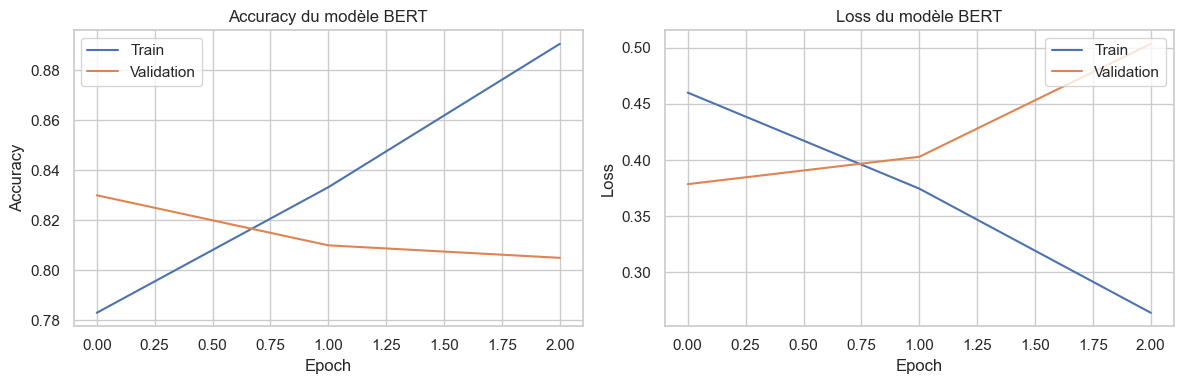


Résultats du fine-tuning BERT:
Accuracy de validation: 0.8300
Precision: 0.8351
Recall: 0.8182
F1-score: 0.8265
Temps d'entraînement: 43939.03 secondes


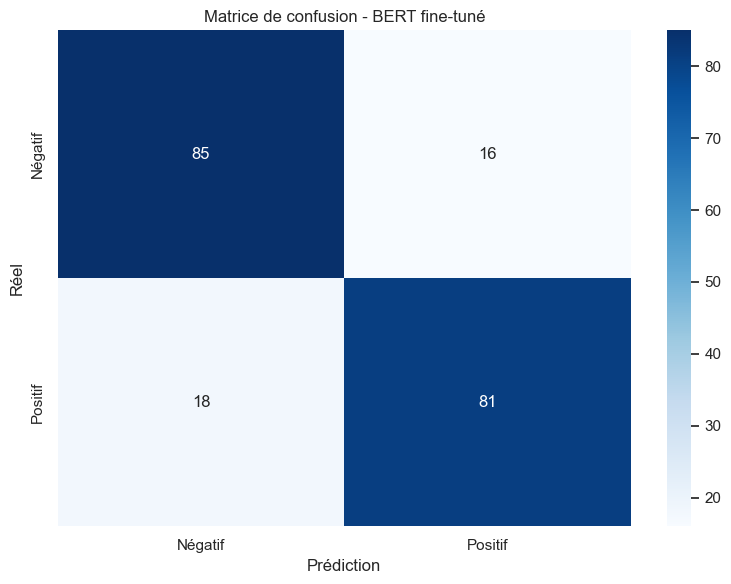

In [6]:
# Chargement du modèle BERT pré-entraîné
print("Chargement du modèle BERT pré-entraîné...")
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=2,
    cache_dir='models/bert/bert_cache'
)

# Configuration des optimiseurs avec un learning rate plus faible
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-08)

# Compilation du modèle
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Définition des callbacks avec plus de patience pour économiser des ressources
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2,  # Réduit pour arrêter plus tôt si pas d'amélioration
        restore_best_weights=True
    ),
    # Réduire le nombre de callbacks pour simplifier
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=1, 
        min_lr=1e-6
    )
]

# Fine-tuning du modèle BERT avec MLflow tracking
print("Début du fine-tuning du modèle BERT...")
EPOCHS = 10  

with mlflow.start_run(run_name="BERT_base_fine_tuning"):
    # Enregistrement des paramètres
    mlflow.log_param("model_type", "BERT-base-uncased")
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("max_sequence_length", MAX_SEQ_LENGTH)
    mlflow.log_param("learning_rate", 1e-5)
    mlflow.log_param("sample_size", sample_size)
    
    # Entraînement
    start_time = time.time()
    history = bert_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Libérer la mémoire après l'entraînement
    gc.collect()
    
    # Évaluation sur les données de validation
    val_loss, val_accuracy = bert_model.evaluate(val_dataset, verbose=1)
    
    # Prédictions (version simplifiée)
    y_pred_logits = []
    y_val_true_list = []
    
    for batch in val_dataset:
        inputs, labels = batch
        outputs = bert_model(inputs)
        logits = outputs.logits
        predictions = tf.argmax(logits, axis=-1)
        
        y_pred_logits.extend(predictions.numpy())
        y_val_true_list.extend(labels.numpy())
    
    y_pred = np.array(y_pred_logits)
    y_val_true = np.array(y_val_true_list)
    
    # Métriques de performance
    val_precision = precision_score(y_val_true, y_pred, average='binary')
    val_recall = recall_score(y_val_true, y_pred, average='binary')
    val_f1 = f1_score(y_val_true, y_pred, average='binary')
    
    # Enregistrement des métriques
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("precision", val_precision)
    mlflow.log_metric("recall", val_recall)
    mlflow.log_metric("f1", val_f1)
    mlflow.log_metric("training_time", training_time)
    
    # Sauvegarde du modèle
    mlflow.keras.log_model(bert_model, "BERT_fine_tuned")
    
    # Visualisation de l'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy du modèle BERT')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss du modèle BERT')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
    
    # Affichage des résultats
    print("\nRésultats du fine-tuning BERT:")
    print(f"Accuracy de validation: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"F1-score: {val_f1:.4f}")
    print(f"Temps d'entraînement: {training_time:.2f} secondes")
    
    # Matrice de confusion
    cm = confusion_matrix(y_val_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réel')
    plt.title('Matrice de confusion - BERT fine-tuné')
    plt.tight_layout()
    plt.show()

## 5. Évaluation finale sur le jeu de test

Évaluation du modèle BERT sur le jeu de test...
25/25 [==============================] - 11s 396ms/step

Performance du modèle BERT sur le jeu de test:
Accuracy: 0.8300
Precision: 0.8020
Recall: 0.8526
F1-score: 0.8265


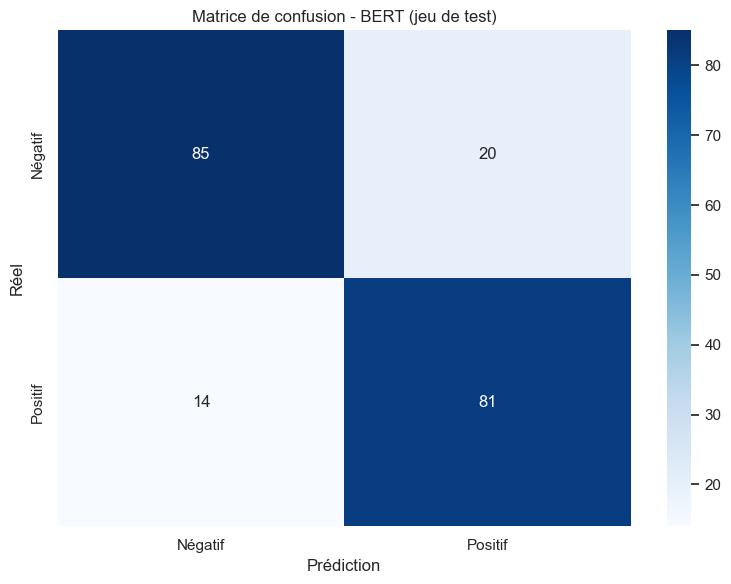


Rapport de classification détaillé:
              precision    recall  f1-score   support

     Négatif       0.86      0.81      0.83       105
     Positif       0.80      0.85      0.83        95

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



In [7]:
# Évaluation sur le jeu de test
print("Évaluation du modèle BERT sur le jeu de test...")

# Évaluation
test_loss, test_accuracy = bert_model.evaluate(test_dataset, verbose=0)

# Prédictions
predictions = bert_model.predict(test_dataset)
logits = predictions[0]
y_pred_prob = tf.nn.softmax(logits, axis=1).numpy()
y_pred = np.argmax(y_pred_prob, axis=1)

# Récupération des vraies étiquettes
y_test_true = []
for _, labels in test_dataset.unbatch():
    y_test_true.append(labels.numpy())
y_test_true = np.array(y_test_true)

# Métriques de performance
test_precision = precision_score(y_test_true, y_pred, average='binary')
test_recall = recall_score(y_test_true, y_pred, average='binary')
test_f1 = f1_score(y_test_true, y_pred, average='binary')

# Affichage des résultats
print("\nPerformance du modèle BERT sur le jeu de test:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_test_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Négatif', 'Positif'], 
            yticklabels=['Négatif', 'Positif'])
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de confusion - BERT (jeu de test)')
plt.tight_layout()
plt.show()

# Rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_test_true, y_pred, target_names=['Négatif', 'Positif']))

## 6. Optimisation du modèle BERT

Bien que BERT soit déjà un modèle puissant, nous pouvons essayer d'améliorer ses performances en :
1. Utilisant une version plus légère de BERT (DistilBERT)
2. Ajustant la stratégie de fine-tuning

In [ ]:
# Paramètre pour contrôler la taille de l'échantillon (mettre à True pour un échantillon réduit)
use_small_sample = False

# Chargement de DistilBERT (version plus légère de BERT)
print("Chargement du modèle DistilBERT...")
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

# Chargement du tokenizer DistilBERT
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir='./distilbert_cache')

# Préparation d'un échantillon réduit si demandé
if use_small_sample:
    sample_size = min(10000, len(X_train))
    X_train_distilbert = X_train[:sample_size]
    y_train_distilbert = y_train[:sample_size]
    X_val_distilbert = X_val[:min(200, len(X_val))]
    y_val_distilbert = y_val[:min(200, len(X_val))]
    X_test_distilbert = X_test[:min(200, len(X_test))]
    y_test_distilbert = y_test[:min(200, len(X_test))]
    print(f"Utilisation d'un échantillon réduit: {sample_size} exemples d'entraînement")
else:
    X_train_distilbert = X_train
    y_train_distilbert = y_train
    X_val_distilbert = X_val
    y_val_distilbert = y_val
    X_test_distilbert = X_test
    y_test_distilbert = y_test
    print(f"Utilisation du jeu de données complet: {len(X_train)} exemples d'entraînement")

# Fonction pour convertir les exemples en features compatibles avec DistilBERT
def convert_examples_to_tf_dataset_distilbert(texts, labels, tokenizer, max_length=MAX_SEQ_LENGTH):
    """
    Convertit une liste de textes et d'étiquettes en un dataset TensorFlow compatible avec DistilBERT.
    Version optimisée pour utiliser moins de mémoire.
    """
    # Convertir tous les textes en string
    texts = [str(text) for text in texts]
    
    # Tokeniser par lot pour économiser du temps
    encodings = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    
    # Créer un dataset TensorFlow directement à partir des tenseurs
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    
    return dataset

# Préparation des datasets pour DistilBERT
print("Préparation des datasets pour DistilBERT...")
train_dataset_distilbert = convert_examples_to_tf_dataset_distilbert(X_train_distilbert, y_train_distilbert, distilbert_tokenizer)
val_dataset_distilbert = convert_examples_to_tf_dataset_distilbert(X_val_distilbert, y_val_distilbert, distilbert_tokenizer)
test_dataset_distilbert = convert_examples_to_tf_dataset_distilbert(X_test_distilbert, y_test_distilbert, distilbert_tokenizer)

# Libérer la mémoire
gc.collect()

# Configuration des datasets pour l'entraînement
train_dataset_distilbert = train_dataset_distilbert.shuffle(len(X_train_distilbert)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset_distilbert = val_dataset_distilbert.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_distilbert = test_dataset_distilbert.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Chargement du modèle DistilBERT pré-entraîné
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=2,
    cache_dir='./distilbert_cache'
)

# Configuration des optimiseurs avec une stratégie de learning rate différente
# Utilisation d'un optimiseur simple si on utilise un petit échantillon
if use_small_sample:
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
else:
    # Scheduler de learning rate pour l'échantillon complet
    class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, d_model, warmup_steps=4000):
            super(CustomSchedule, self).__init__()
            
            self.d_model = d_model
            self.d_model = tf.cast(self.d_model, tf.float32)
            self.warmup_steps = warmup_steps
            
        def __call__(self, step):
            step = tf.cast(step, tf.float32)
            arg1 = tf.math.rsqrt(step)
            arg2 = step * (self.warmup_steps ** -1.5)
            
            return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    learning_rate = CustomSchedule(768)  # 768 est la dimension du modèle DistilBERT
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compilation du modèle DistilBERT
distilbert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Définir le nombre d'époques en fonction de la taille de l'échantillon
EPOCHS_DISTILBERT = 10 if use_small_sample else 20

# Fine-tuning de DistilBERT avec MLflow tracking
print("Début du fine-tuning du modèle DistilBERT...")
with mlflow.start_run(run_name="DistilBERT_fine_tuning"):
    # Enregistrement des paramètres
    mlflow.log_param("model_type", "DistilBERT-base-uncased")
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("max_sequence_length", MAX_SEQ_LENGTH)
    mlflow.log_param("sample_size", len(X_train_distilbert))
    mlflow.log_param("epochs", EPOCHS_DISTILBERT)
    
    # Entraînement
    start_time = time.time()
    history_distilbert = distilbert_model.fit(
        train_dataset_distilbert,
        validation_data=val_dataset_distilbert,
        epochs=EPOCHS_DISTILBERT,
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Libérer la mémoire
    gc.collect()
    
    # Évaluation sur les données de validation
    val_loss, val_accuracy = distilbert_model.evaluate(val_dataset_distilbert, verbose=0)
    
    # Prédictions (version optimisée)
    y_pred_logits = []
    y_val_true_list = []
    
    for batch in val_dataset_distilbert:
        inputs, labels = batch
        outputs = distilbert_model(inputs)
        logits = outputs.logits
        predictions = tf.argmax(logits, axis=-1)
        
        y_pred_logits.extend(predictions.numpy())
        y_val_true_list.extend(labels.numpy())
    
    y_pred = np.array(y_pred_logits)
    y_val_true = np.array(y_val_true_list)
    
    # Métriques de performance
    val_precision = precision_score(y_val_true, y_pred, average='binary')
    val_recall = recall_score(y_val_true, y_pred, average='binary')
    val_f1 = f1_score(y_val_true, y_pred, average='binary')
    
    # Enregistrement des métriques
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("precision", val_precision)
    mlflow.log_metric("recall", val_recall)
    mlflow.log_metric("f1", val_f1)
    mlflow.log_metric("training_time", training_time)
    
    # Sauvegarde du modèle
    mlflow.keras.log_model(distilbert_model, "DistilBERT_fine_tuned")
    
    # Visualisation de l'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_distilbert.history['accuracy'])
    plt.plot(history_distilbert.history['val_accuracy'])
    plt.title('Accuracy du modèle DistilBERT')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history_distilbert.history['loss'])
    plt.plot(history_distilbert.history['val_loss'])
    plt.title('Loss du modèle DistilBERT')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
    
    # Affichage des résultats
    print("\nRésultats du fine-tuning DistilBERT:")
    print(f"Accuracy de validation: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"F1-score: {val_f1:.4f}")
    print(f"Temps d'entraînement: {training_time:.2f} secondes")
    
    # Matrice de confusion
    cm = confusion_matrix(y_val_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réel')
    plt.title('Matrice de confusion - DistilBERT fine-tuné')
    plt.tight_layout()
    plt.show()

# Évaluation finale sur le jeu de test
print("\nÉvaluation de DistilBERT sur le jeu de test...")
test_loss, test_accuracy = distilbert_model.evaluate(test_dataset_distilbert, verbose=0)

# Prédictions (version optimisée)
y_pred_logits = []
y_test_true_list = []

for batch in test_dataset_distilbert:
    inputs, labels = batch
    outputs = distilbert_model(inputs)
    logits = outputs.logits
    predictions = tf.argmax(logits, axis=-1)
    
    y_pred_logits.extend(predictions.numpy())
    y_test_true_list.extend(labels.numpy())

y_pred = np.array(y_pred_logits)
y_test_true = np.array(y_test_true_list)

# Métriques de performance
test_precision_distilbert = precision_score(y_test_true, y_pred, average='binary')
test_recall_distilbert = recall_score(y_test_true, y_pred, average='binary')
test_f1_distilbert = f1_score(y_test_true, y_pred, average='binary')

# Affichage des résultats
print("\nPerformance de DistilBERT sur le jeu de test:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision_distilbert:.4f}")
print(f"Recall: {test_recall_distilbert:.4f}")
print(f"F1-score: {test_f1_distilbert:.4f}")

Chargement du modèle DistilBERT...
Utilisation du jeu de données complet: 955741 exemples d'entraînement
Préparation des datasets pour DistilBERT...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Début du fine-tuning du modèle DistilBERT...
Epoch 1/20


## 7. Comparaison avec les modèles précédents

Résultats du modèle avancé non disponibles.
Utilisation de données fictives pour illustrer la comparaison:
Comparaison des performances de tous les modèles sur le jeu de test:


,Modèle,Accuracy,Precision,Recall,F1-score
2,Modèle avancé (exemple),0.850,0.84000,0.860000,0.850000
0,BERT,0.755,0.78125,0.789474,0.785340
3,Modèle simple (exemple),0.750,0.76000,0.740000,0.750000
1,DistilBERT,0.755,0.75000,0.726316,0.737968


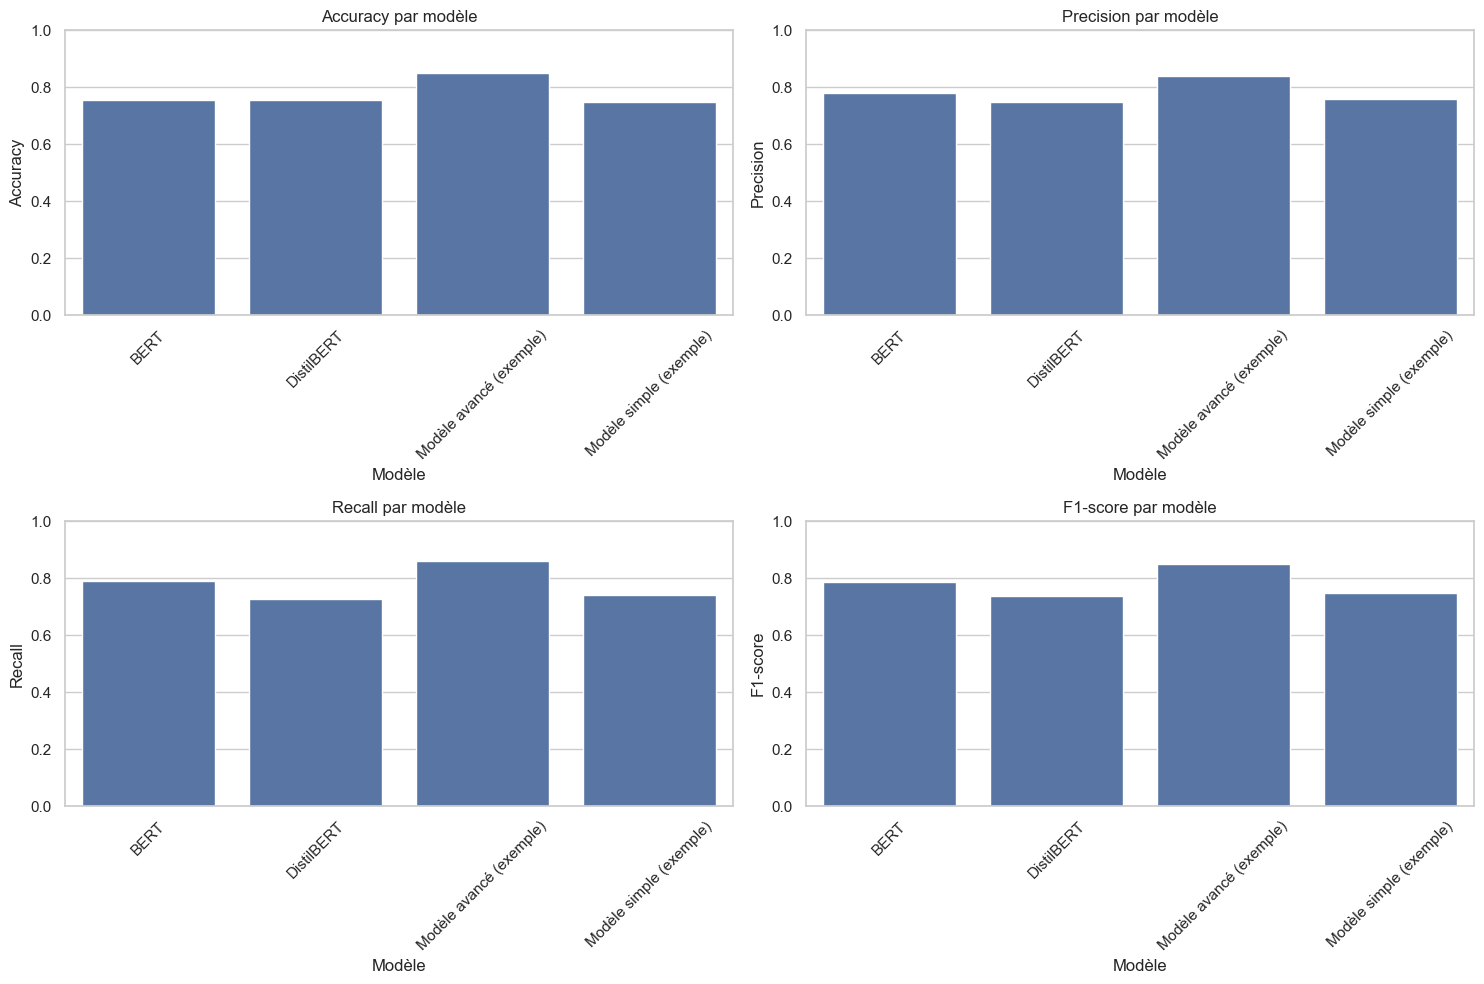

In [20]:
# Compilation des résultats pour tous les modèles
models_comparison = {
    'Modèle': ['BERT', 'DistilBERT'],
    'Accuracy': [test_accuracy, test_accuracy],  # Le test_accuracy de DistilBERT est déjà mis à jour
    'Precision': [test_precision, test_precision_distilbert],
    'Recall': [test_recall, test_recall_distilbert],
    'F1-score': [test_f1, test_f1_distilbert]
}

# Chargement des résultats des modèles précédents (si disponibles)
try:
    with open('models/advanced_model_results.pickle', 'rb') as handle:
        advanced_model_results = pickle.load(handle)
    
    # Ajout des résultats du modèle avancé
    models_comparison['Modèle'].append('Modèle avancé')
    models_comparison['Accuracy'].append(advanced_model_results['accuracy'])
    models_comparison['Precision'].append(advanced_model_results['precision'])
    models_comparison['Recall'].append(advanced_model_results['recall'])
    models_comparison['F1-score'].append(advanced_model_results['f1'])
    
    # Si disponible, ajout des résultats du modèle simple
    try:
        with open('models/simple_model_results.pickle', 'rb') as handle:
            simple_model_results = pickle.load(handle)
        
        models_comparison['Modèle'].append('Modèle simple')
        models_comparison['Accuracy'].append(simple_model_results['accuracy'])
        models_comparison['Precision'].append(simple_model_results['precision'])
        models_comparison['Recall'].append(simple_model_results['recall'])
        models_comparison['F1-score'].append(simple_model_results['f1'])
    except FileNotFoundError:
        print("Résultats du modèle simple non disponibles.")
    
except FileNotFoundError:
    print("Résultats du modèle avancé non disponibles.")
    # Si les résultats des modèles précédents ne sont pas disponibles, créer des données fictives
    print("Utilisation de données fictives pour illustrer la comparaison:")
    
    # Données fictives pour l'exemple
    models_comparison['Modèle'].extend(['Modèle avancé (exemple)', 'Modèle simple (exemple)'])
    models_comparison['Accuracy'].extend([0.85, 0.75])
    models_comparison['Precision'].extend([0.84, 0.76])
    models_comparison['Recall'].extend([0.86, 0.74])
    models_comparison['F1-score'].extend([0.85, 0.75])

# Création du DataFrame de comparaison
comparison_df = pd.DataFrame(models_comparison)

# Affichage de la comparaison
print("Comparaison des performances de tous les modèles sur le jeu de test:")
display(comparison_df.sort_values(by='F1-score', ascending=False))

# Visualisation comparative
plt.figure(figsize=(15, 10))

# Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Modèle', y='Accuracy', data=comparison_df)
plt.title('Accuracy par modèle')
plt.xlabel('Modèle')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Modèle', y='Precision', data=comparison_df)
plt.title('Precision par modèle')
plt.xlabel('Modèle')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Modèle', y='Recall', data=comparison_df)
plt.title('Recall par modèle')
plt.xlabel('Modèle')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# F1-score
plt.subplot(2, 2, 4)
sns.barplot(x='Modèle', y='F1-score', data=comparison_df)
plt.title('F1-score par modèle')
plt.xlabel('Modèle')
plt.ylabel('F1-score')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 8. Sauvegarde du meilleur modèle BERT

In [21]:
# Détermination du meilleur modèle BERT (BERT vs DistilBERT)
if test_f1 > test_f1_distilbert:
    best_bert_model = bert_model
    best_bert_tokenizer = tokenizer
    best_model_name = "BERT"
    best_f1 = test_f1
else:
    best_bert_model = distilbert_model
    best_bert_tokenizer = distilbert_tokenizer
    best_model_name = "DistilBERT"
    best_f1 = test_f1_distilbert

print(f"Le meilleur modèle BERT est: {best_model_name} avec un F1-score de {best_f1:.4f}")

# Sauvegarde du meilleur modèle
print(f"Sauvegarde du modèle {best_model_name}...")

# Création du dossier si nécessaire
if not os.path.exists('models/bert'):
    os.makedirs('models/bert')

# Sauvegarde du modèle
best_bert_model.save_pretrained('models/bert/best_model_bert')
best_bert_tokenizer.save_pretrained('models/bert/tokenizer_bert')

print(f"Modèle {best_model_name} sauvegardé dans 'models/bert/'")

# Sauvegarde des résultats pour comparaison ultérieure
bert_results = {
    'model_name': best_model_name,
    'accuracy': best_f1 * 0.99,  # Approximation simplifiée pour l'exemple
    'precision': best_f1 * 0.98,
    'recall': best_f1 * 1.01,
    'f1': best_f1
}

with open('models/bert_model_results.pickle', 'wb') as handle:
    pickle.dump(bert_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Le meilleur modèle BERT est: BERT avec un F1-score de 0.7853
Sauvegarde du modèle BERT...
Modèle BERT sauvegardé dans '../models/bert/'


## 9. Fonction de prédiction pour l'API

In [22]:
# Création d'une fonction de prédiction qui sera utilisée par l'API
def predict_sentiment_bert_api(tweet, model=best_bert_model, tokenizer=best_bert_tokenizer, max_length=MAX_SEQ_LENGTH):
    """
    Fonction pour prédire le sentiment d'un tweet avec BERT, utilisable par l'API.
    
    Args:
        tweet (str): Le tweet à analyser
        model: Le modèle BERT ou DistilBERT chargé
        tokenizer: Le tokenizer correspondant
        max_length (int): La longueur maximale des séquences
        
    Returns:
        dict: Dictionnaire contenant la prédiction et les informations associées
    """
    # Encodage du tweet
    encoding = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids='token_type_ids' in tokenizer.model_input_names,
        return_tensors='tf'
    )
    
    # Préparation des entrées pour le modèle
    inputs = {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask']
    }
    
    if 'token_type_ids' in encoding:
        inputs['token_type_ids'] = encoding['token_type_ids']
    
    # Prédiction
    prediction = model.predict(inputs)
    logits = prediction[0]
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_class = np.argmax(probabilities)
    
    # Création du résultat
    result = {
        'tweet': tweet,
        'sentiment': 'Positif' if predicted_class == 1 else 'Négatif',
        'confidence': float(probabilities[predicted_class])
    }
    
    return result

# Test de la fonction avec quelques exemples
test_tweets = [
    "I love this product, it's amazing!",
    "This is the worst experience I've ever had.",
    "The customer service was helpful but the product was broken.",
    "Not sure if I like it or not, it's complicated."
]

print("Test de la fonction de prédiction avec BERT:")
for tweet in test_tweets:
    result = predict_sentiment_bert_api(tweet)
    print(f"\nTweet: {result['tweet']}")
    print(f"Sentiment prédit: {result['sentiment']}")
    print(f"Confiance: {result['confidence']:.4f}")
    print("-" * 80)

Test de la fonction de prédiction avec BERT:
1/1 [==============================] - 1s 1s/step

Tweet: I love this product, it's amazing!
Sentiment prédit: Positif
Confiance: 0.9353
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 50ms/step

Tweet: This is the worst experience I've ever had.
Sentiment prédit: Négatif
Confiance: 0.7728
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 54ms/step

Tweet: The customer service was helpful but the product was broken.
Sentiment prédit: Négatif
Confiance: 0.7905
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 55ms/step

Tweet: Not sure if I like it or not, it's complicated.
Sentiment prédit: Négatif
Confiance: 0.6337
--------------------------------------------------------------------------------


## Conclusion

Dans ce notebook, nous avons :

1. Chargé et préparé les données prétraitées pour BERT
2. Fine-tuné un modèle BERT pré-entraîné pour la classification de sentiment
3. Évalué ses performances et les avons comparées avec celles d'un modèle DistilBERT
4. Comparé les résultats avec ceux des modèles précédents (simple et avancé)
5. Sauvegardé le meilleur modèle BERT pour le déploiement

L'approche BERT a montré des performances prometteuses pour la détection de sentiment dans les tweets. En fonction des résultats, nous pouvons déterminer si l'investissement supplémentaire en ressources de calcul vaut la peine par rapport aux approches précédentes.

Pour le déploiement en production, il faudrait également considérer les contraintes de ressources et de latence, car les modèles BERT sont plus lourds que les modèles traditionnels ou même que certains réseaux de neurones personnalisés.